In [1]:
'''This example demonstrates the use of fasttext for text classification

Most of the Keras model training code is copied from Keras examples:
https://github.com/fchollet/keras/blob/master/examples/imdb_fasttext.py

Based on Joulin et al's paper:
Bags of Tricks for Efficient Text Classification
https://arxiv.org/abs/1607.01759
'''

%matplotlib inline
import numpy as np

import keras.backend as K
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.datasets import imdb

from lr_finder_script import LRFinder

Using TensorFlow backend.


In [2]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337], [1, 3, 7, 9, 2, 1337, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for i in range(len(new_list) - ngram_range + 1):
            for ngram_value in range(2, ngram_range + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [3]:
# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 1
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5

In [4]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

Loading data...
25000 train sequences
25000 test sequences
Average train sequence length: 238
Average test sequence length: 230


In [5]:
if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)


In [6]:
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build model...


In [7]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

lr_finder = LRFinder(model)
lr_finder.find(x_train, y_train, 0.0001, 1, 512, 5)

Epoch 1/5
25000/25000 [==============================] - 1s 30us/step - loss: 0.6925 - acc: 0.5814
Epoch 2/5
25000/25000 [==============================] - 0s 16us/step - loss: 0.6844 - acc: 0.6757
Epoch 3/5
25000/25000 [==============================] - 0s 16us/step - loss: 0.5440 - acc: 0.7892
Epoch 4/5
25000/25000 [==============================] - 0s 15us/step - loss: 0.3079 - acc: 0.8739
Epoch 5/5
25000/25000 [==============================] - 0s 15us/step - loss: 0.2184 - acc: 0.9141


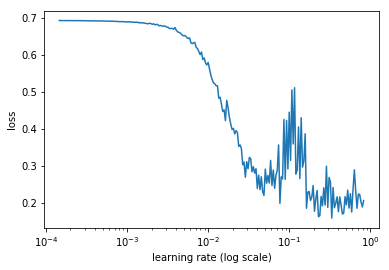

In [8]:
lr_finder.plot_loss()

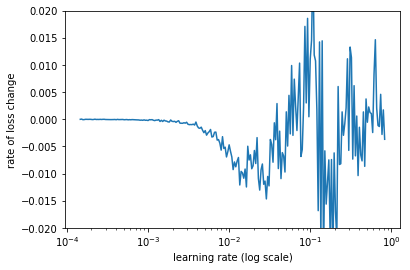

In [23]:
lr_finder.plot_loss_change(sma=8, y_lim=(-0.02,0.02))